In [118]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

%matplotlib inline

We need to generate an input file that the BPASS script can read so it can parse through the Geneva tracks. First lets figure out the IMF

In [2]:
inputfile = '../input_bpass_z002_sin_imf135_300'
masses = []
weights = []
f = open(inputfile,'r')
tot_imf = f.readline()
while True:
    filename = f.readline()
    if not filename:
        break
    mass = filename.split('-')[-1]
    masses.append(float(mass))
    imf_line = f.readline()
    imf_weight = imf_line.split()[0]
    weights.append(float(imf_weight))
f.close()
masses = np.flip(masses)
weights = np.flip(weights)

In [3]:
masses[5],weights[5]

(0.2, 62405.993)

[None, None]

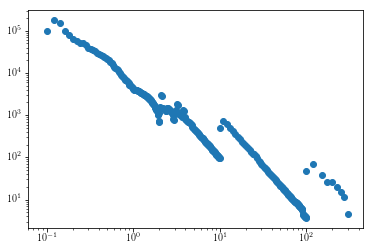

In [4]:
plt.scatter(masses, weights)
plt.gca().set(xscale='log',yscale='log')

The IMF looks like:

$\Phi(M) = AM^{-\alpha}$

If the slope changes at $M_*$ from $\alpha_1$ (low mass slope) to $\alpha_2$ (high mass slope), we require the IMF the yield the same value given both slopes, requiring two different normalizations. If we know the high mass slope (e.g., Salpeter 2.35 IMF) and normalization:

$A_1M_*^{-\alpha_1} = A_2M_*^{-\alpha_2}$

$A_1 = A_2 M_*^{\alpha_1 - \alpha_2}$

In [5]:
def IMF(mass,hi_mass_normalization=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    lo_mass_normalization = hi_mass_normalization*m_star**(lo_mass_slope-hi_mass_slope)
    if hasattr(mass,'__len__'):
        out = []
        for m in mass:
            if (m < lo_mass_cut) or (m > hi_mass_cut):
                out.append(0)
            elif (m <= m_star):
                out.append(lo_mass_normalization*m**-lo_mass_slope)
            else:
                out.append(hi_mass_normalization*m**-hi_mass_slope)
        return out
    else:
        if (mass < lo_mass_cut) or (mass > hi_mass_cut):
            return 0
        elif (mass <= m_star):
            return lo_mass_normalization*mass**-lo_mass_slope
        else:
            return hi_mass_normalization*mass**-hi_mass_slope

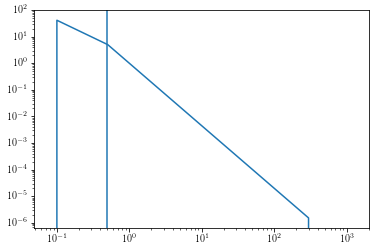

In [6]:
#is the function working correctly?
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = IMF(test_masses)
plt.loglog(test_masses, test_imf)
plt.axvline(x=0.5)

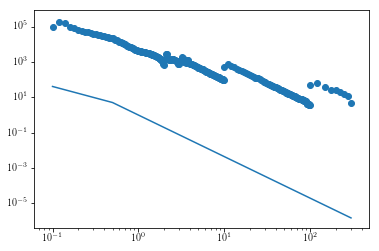

In [7]:
#are the weights just the raw IMF? (no)
plt.loglog(masses,IMF(masses))
plt.scatter(masses,weights)

In [87]:
#Because this is discretized, we need to decide on bin edges. Two options: have bin edges
#evenly spaced between masses on a linear scale, or evenly spaced on a log scale 
def make_bin_edges(model_masses,scale='log',lo_mass_cut=0.1,hi_mass_cut=300):
    """
    Given the masses of your evolutionary tracks, makes bin edges for them. 
    Bin edges are either chosen to be the linear or logarithmic average between two
    mass points.
    
    Parameters
    ----------
    model_masses : array-like
        Initial masses of all of your evolutionary tracks.
        
    scale : str
        Decides how to bin up the IMF. Values: 'log' or 'linear', default 'log'
        
    lo_mass_cut : float
        Low mass cutoff of the IMF in solar masses, default 0.1.
        
    hi_mass_cut : float
        High mass cutoff of the IMF in solar masses, default 300.
        
    Returns
    -------
    bin_edges : array-like
        Edges of the IMF bins.  
    
    """
    
    assert scale in ['log','linear'], "Please choose a log or linear scale"
    
    model_masses = np.sort(model_masses)
    
    bin_edges = [lo_mass_cut]
    for i,m in enumerate(model_masses[:-1]):
        #if the mass is outside the IMF cutoffs, then we don't want it.
        if (m<lo_mass_cut) or (m>=hi_mass_cut):
            pass
        else: #now lets figure out the next highest bin edge
            next_mass = model_masses[i+1]
            if scale == 'linear':
                average = 0.5*(m + next_mass)
            else:
                average = np.power(m * next_mass,0.5)
            bin_edges.append(np.min([average,hi_mass_cut]))
    if hi_mass_cut not in bin_edges:
        bin_edges.append(hi_mass_cut)
    return np.array(bin_edges)

[Text(0, 0.5, 'Weight'), Text(0.5, 0, 'Mass [$M_\\odot$]')]

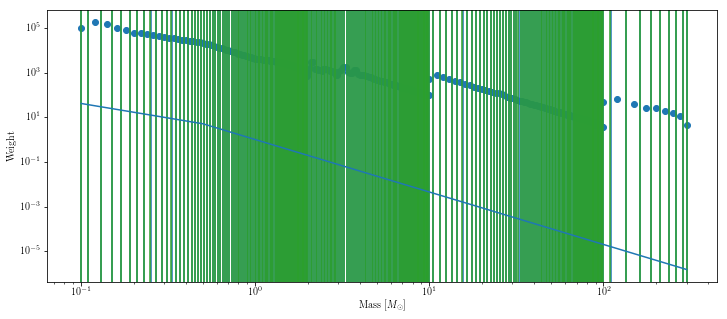

In [99]:
fig = plt.figure(figsize=(12,5))
ms = np.linspace(1,5,5)
linear_bin_edges = make_bin_edges(masses,scale='linear')
log_bin_edges = make_bin_edges(masses)
plt.scatter(masses,weights)
for e in linear_bin_edges:
    plt.axvline(x=e)
for le in log_bin_edges:
    plt.axvline(x=le,c='C2')
plt.loglog(masses,IMF(masses))
plt.gca().set(xlabel='Mass [$M_\odot$]',ylabel='Weight')

[None, None]

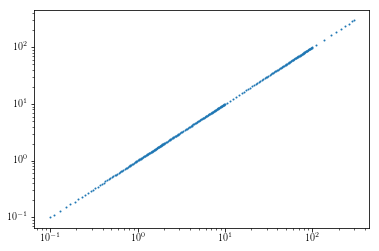

In [101]:
plt.scatter(linear_bin_edges,log_bin_edges,s=1)
plt.gca().set(xscale='log',yscale='log')

First let's figure out the total number of stars formed. In BPASS, that's just the sum of the weights, $N_*$. For our IMF, with lower limit $M_l$, upper limit $M_u$, and threshold mass $M_*$, that's going to be the integral

$N = \int_{M_l}^{M_u}\Phi(M)dM = \int_{M_l}^{M_*}A_1M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

We can substitute in for the lower mass normalization:

$N = \int_{M_l}^{M_*}A_2M_*^{\alpha_1-\alpha_2}M^{-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{-\alpha_2}dM$

Solving directly:

$N = A_2 \bigg[\frac{M_*^{\alpha_1-\alpha_2}M^{1-\alpha_1}}{1-\alpha_1}\Big|_{M_l}^{M_*} + \frac{M^{1-\alpha_2}}{1-\alpha_2}\Big|_{M_*}^{M_u}\bigg]$ 

$N = A_2\bigg[\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}\bigg]$

So, if we want the weights to work out identically, we can set $N=N_*$, so

$A_2 = \frac{N_*}{\frac{M_*^{1-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{1-\alpha_1}}{1-\alpha_1}+ \frac{M_u^{1-\alpha_2}-M_*^{1-\alpha_2}}{1-\alpha_2}}$

In [102]:
#writing a function to implement this
def IMF_known_stars(mass,N_stars=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    numerator = N_stars
    
    denom1_num = np.power(m_star,1.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,1.0-lo_mass_slope)
    denom1_den = 1.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,1.0-hi_mass_slope) - np.power(m_star,1.0-hi_mass_slope)
    denom2_den = 1.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator

    
    return IMF(mass,hi_mass_normalization=hi_mass_normalization,lo_mass_slope=lo_mass_slope,
              hi_mass_slope=hi_mass_slope,m_star=m_star,lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut)

Alternately, maybe we know the Mass of the population, $M_{tot}$. The total mass is

$M = \int_{M_l}^{M_u}M\Phi(M)dM = \int_{M_l}^{M_*}A_1M^{1-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{1-\alpha_2}dM$

We can substitute in for the lower mass normalization:

$M = \int_{M_l}^{M_*}A_2M_*^{\alpha_1-\alpha_2}M^{1-\alpha_1}dM + \int_{M_*}^{M_u}A_2M^{1-\alpha_2}dM$

Solving directly:

$M = A_2 \bigg[\frac{M_*^{\alpha_1-\alpha_2}M^{2-\alpha_1}}{2-\alpha_1}\Big|_{M_l}^{M_*} + \frac{M^{2-\alpha_2}}{2-\alpha_2}\Big|_{M_*}^{M_u}\bigg]$ 

$M = A_2\bigg[\frac{M_*^{2-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{2-\alpha_1}}{2-\alpha_1}+ \frac{M_u^{2-\alpha_2}-M_*^{2-\alpha_2}}{2-\alpha_2}\bigg]$

So, if we want the weights to work out identically, we can set $M=M_{tot}$, so

$A_2 = \frac{M_{tot}}{\frac{M_*^{2-\alpha_2}-M_*^{\alpha_1-\alpha_2}M_l^{2-\alpha_1}}{2-\alpha_1}+ \frac{M_u^{2-\alpha_2}-M_*^{2-\alpha_2}}{2-\alpha_2}}$

In [104]:
#writing a function to implement this
def IMF_known_mass(mass,M_tot=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    numerator = M_tot
    
    denom1_num = np.power(m_star,2.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,2.0-lo_mass_slope)
    denom1_den = 2.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,2.0-hi_mass_slope) - np.power(m_star,2.0-hi_mass_slope)
    denom2_den = 2.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator

    
    return IMF(mass,hi_mass_normalization=hi_mass_normalization,lo_mass_slope=lo_mass_slope,
              hi_mass_slope=hi_mass_slope,m_star=m_star,lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut)

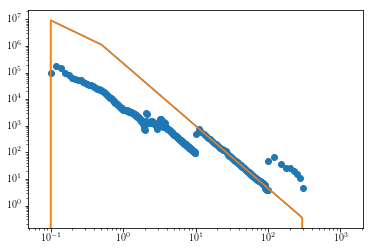

In [109]:
test_masses = np.logspace(-1.1,3.1,1000)
test_imf = np.array(IMF_known_stars(test_masses,np.sum(weights)))
test_imf2 = np.array(IMF_known_mass(test_masses,1e6))
plt.loglog(test_masses,test_imf)
plt.loglog(test_masses,test_imf2)
plt.scatter(masses,weights)

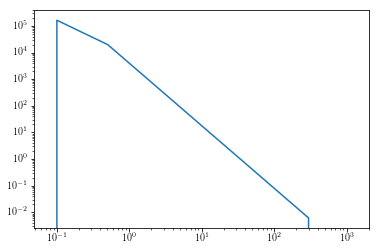

In [111]:
#ok so they don't give QUITE the same answer.
plt.loglog(test_masses,test_imf-test_imf2)

So it's clear we're going to need to perform the integral. Regardless of the bins we choose, the number of stars with mass between $m_1$ and $m_2$ is

$N(m_1,m_2) = \int_{m_1}^{m_2}\Phi(M)dM$

In [112]:
#Now, let's try integrating the IMF over a bin between left and right. Has to handle low/hi
#mass cases, and bins that cross the knee mass

def integrate_IMF_known_stars(left,right,N_stars=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    assert right > left
    
    numerator = N_stars
    
    denom1_num = np.power(m_star,1.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,1.0-lo_mass_slope)
    denom1_den = 1.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,1.0-hi_mass_slope) - np.power(m_star,1.0-hi_mass_slope)
    denom2_den = 1.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator
    
    #trim bin to the mass threshold
    if left < lo_mass_cut:
        left = lo_mass_cut
    
    if right > hi_mass_cut:
        right = hi_mass_cut
    
    if right <= m_star:
        new_slope = 1.0 - lo_mass_slope
        norm = hi_mass_normalization * np.power(m_star,lo_mass_slope-hi_mass_slope) / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))
    
    elif left >= m_star:
        new_slope = 1.0 - hi_mass_slope
        norm = hi_mass_normalization / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))

    
    else: 
        return (integrate_IMF_known_stars(left=left,right=m_star,N_stars=N_stars,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut) +
                integrate_IMF_known_stars(left=m_star,right=right,N_stars=N_stars,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut))

In [113]:
#Same but in case where we know the mass of the cluster

def integrate_IMF_known_mass(left,right,M_tot=1.0,lo_mass_slope=1.3,hi_mass_slope=2.35,m_star=0.5,lo_mass_cut=0.1,hi_mass_cut=300.0):
    
    assert right > left
    
    numerator = M_tot
    
    denom1_num = np.power(m_star,2.0-hi_mass_slope)-np.power(m_star,lo_mass_slope-hi_mass_slope)*np.power(lo_mass_cut,2.0-lo_mass_slope)
    denom1_den = 2.0 - lo_mass_slope
    denom1 = denom1_num/denom1_den
    
    denom2_num = np.power(hi_mass_cut,2.0-hi_mass_slope) - np.power(m_star,2.0-hi_mass_slope)
    denom2_den = 2.0-hi_mass_slope
    denom2 = denom2_num/denom2_den
    
    denomenator = denom1 + denom2
    
    hi_mass_normalization = numerator/denomenator
    
    #trim bin to the mass threshold
    if left < lo_mass_cut:
        left = lo_mass_cut
    
    if right > hi_mass_cut:
        right = hi_mass_cut
    
    if right <= m_star:
        new_slope = 1.0 - lo_mass_slope
        norm = hi_mass_normalization * np.power(m_star,lo_mass_slope-hi_mass_slope) / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))
    
    elif left >= m_star:
        new_slope = 1.0 - hi_mass_slope
        norm = hi_mass_normalization / new_slope
        return norm * (np.power(right,new_slope)-np.power(left,new_slope))

    
    else: 
        return (integrate_IMF_known_mass(left=left,right=m_star,M_tot=M_tot,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut) +
                integrate_IMF_known_mass(left=m_star,right=right,M_tot=M_tot,
                                         lo_mass_slope=lo_mass_slope,
                                         hi_mass_slope=hi_mass_slope,m_star=m_star,
                                         lo_mass_cut=lo_mass_cut,hi_mass_cut=hi_mass_cut))

In [114]:
def as_eight_digits(f):
    """converts number into 8 digit float"""
    
    num_digits_left = int(np.log10(f)) + 1
    num_digits_right = 8 - num_digits_left
    l = str(num_digits_left)
    r = str(num_digits_right)
    out_str = "{0:."+r+"f}"
    return float(out_str.format(f))

In [115]:
# I think it's a bit precision thingy. 
closest_to_power_of_two = []
for pot in np.logspace(3,17,15,base=2):
    m = masses[np.argmin(np.abs(weights-pot))]
    closest_to_power_of_two.append(m)

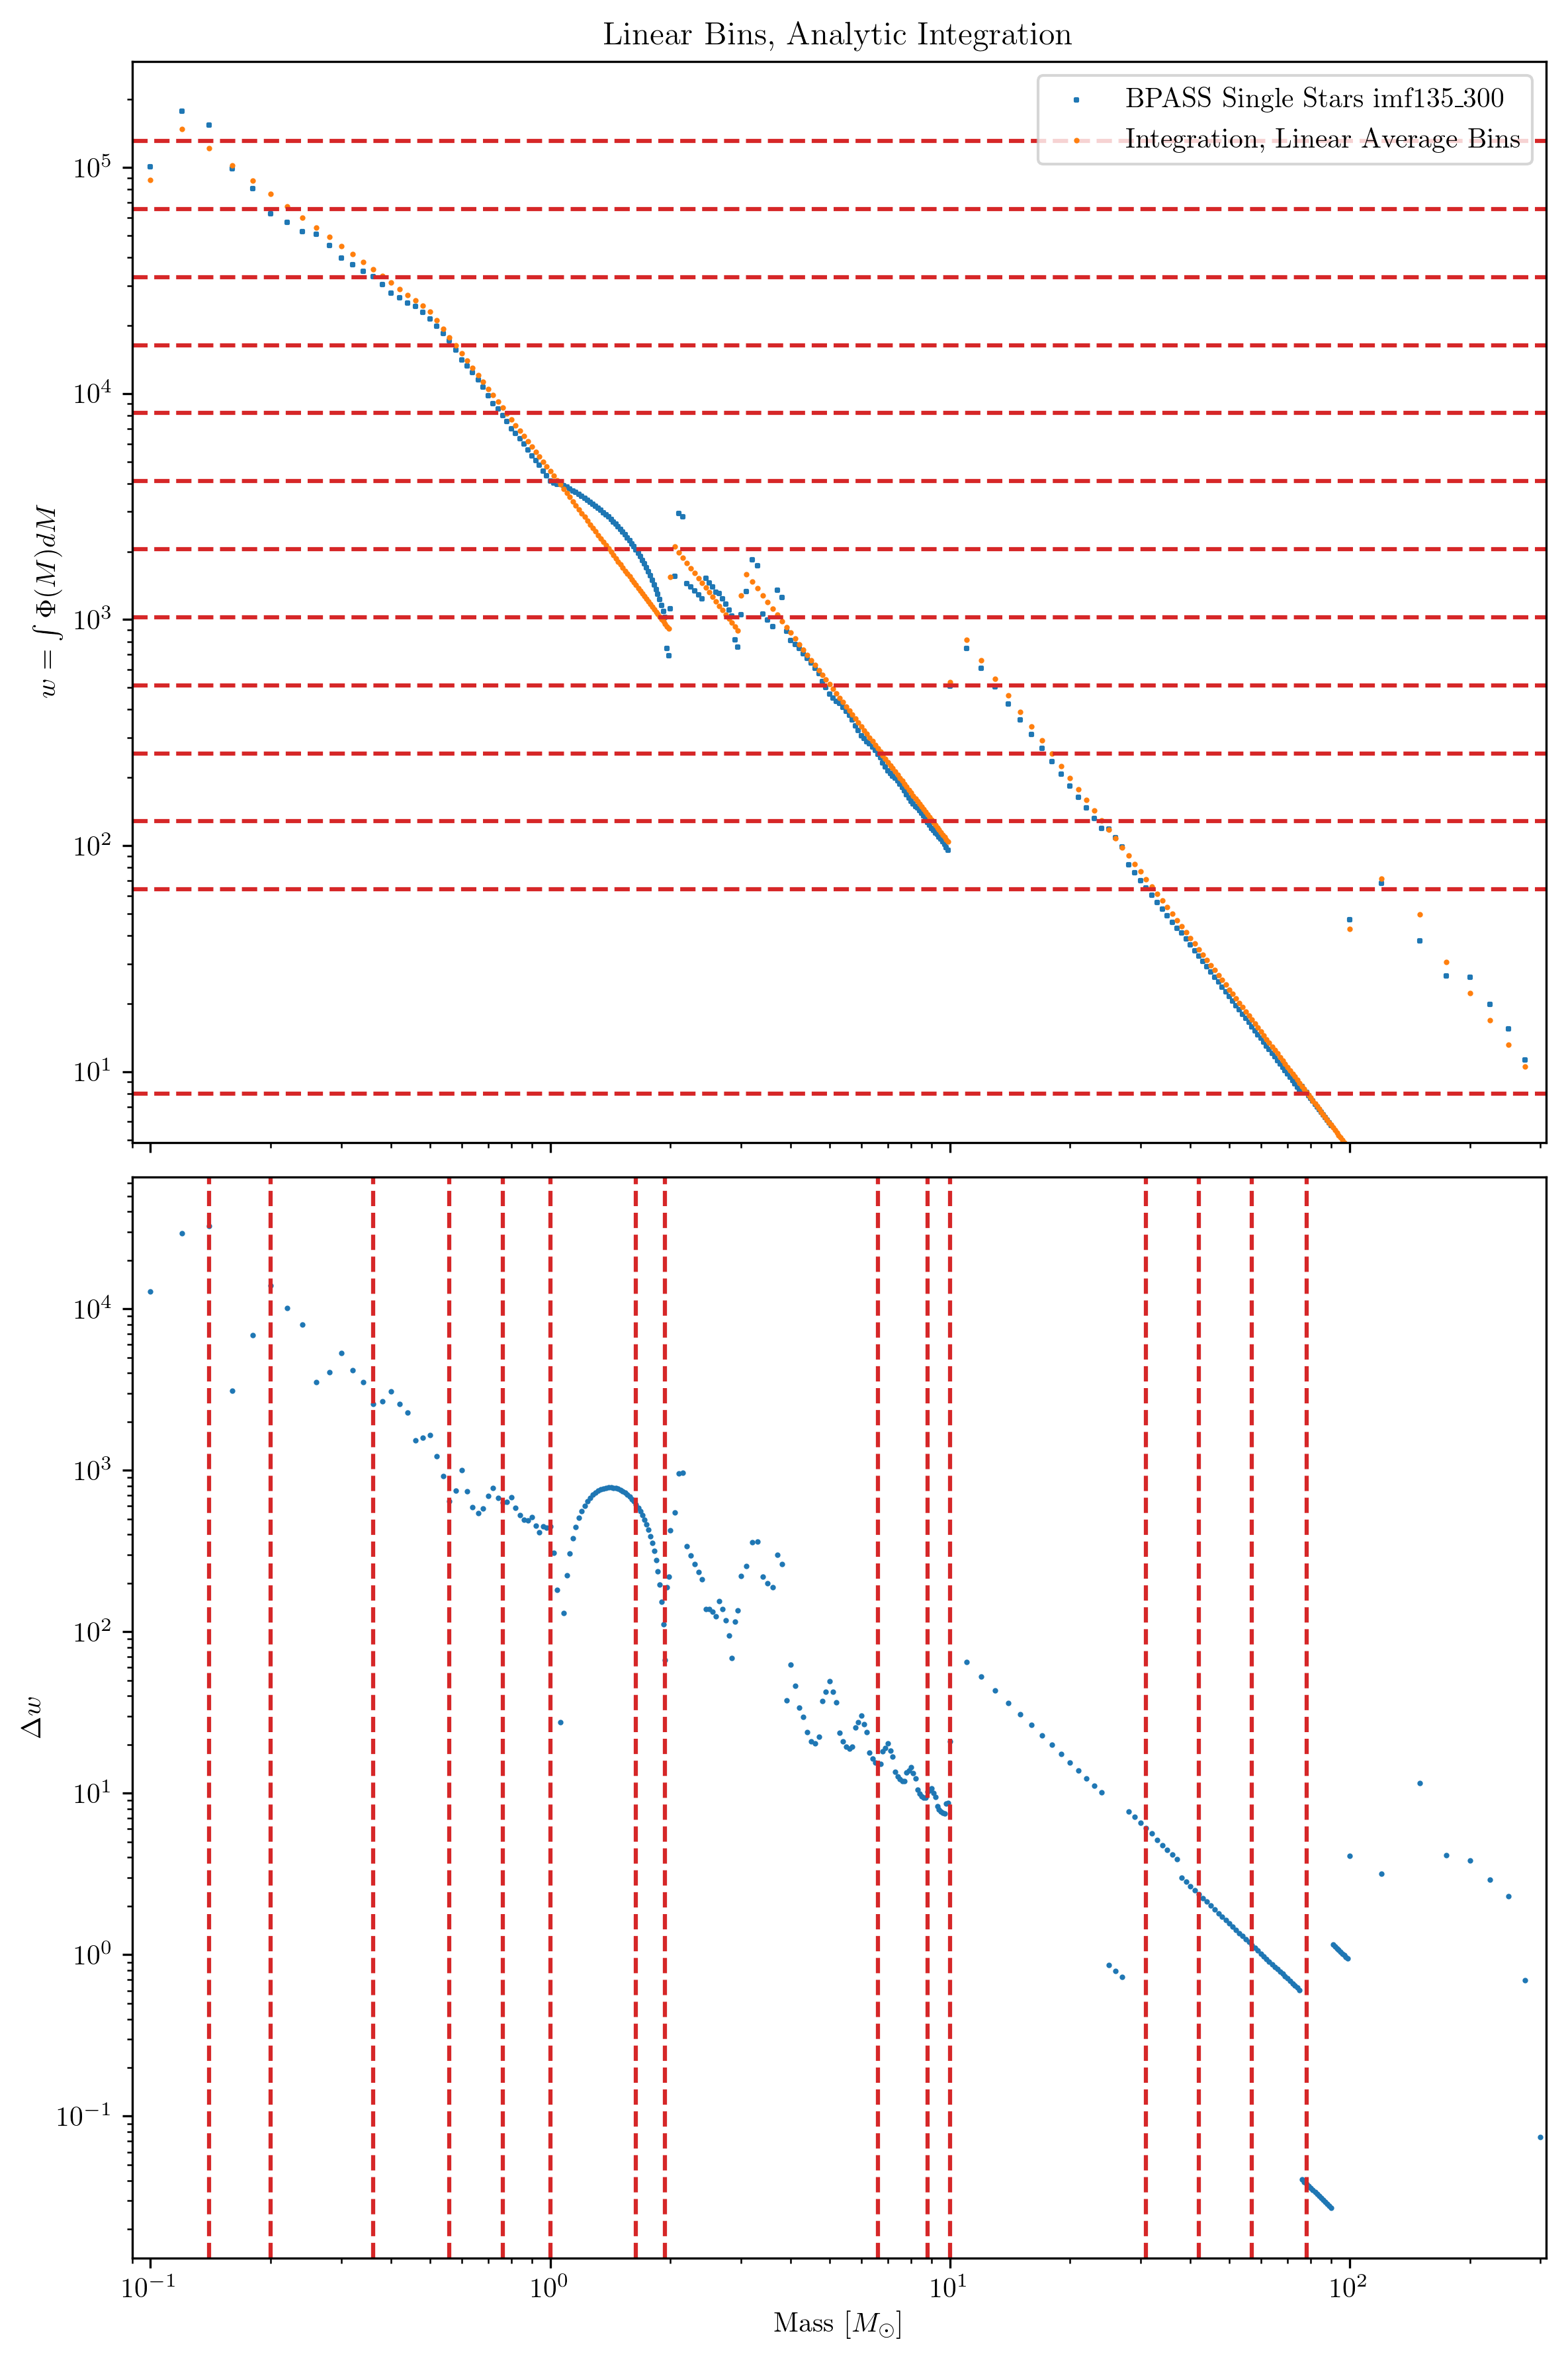

In [116]:
#With that done, let's try integrating over the bins
fig, ax = plt.subplots(2,figsize=(8,12),sharex=True,dpi=300)
linear_test_weights = []
for i,m in enumerate(masses):
    left = linear_bin_edges[i]
    right = linear_bin_edges[i+1]
    test_weight = integrate_IMF_known_stars(left,right,N_stars=np.sum(weights))
    linear_test_weights.append(test_weight)
#for i in np.logspace(1,5,5):
#    ax[0].axhline(y=i,ls='--',c='k')
for i in np.logspace(6,17,12,base=2):
    ax[0].axhline(y=i,ls='--',c='C3')
ax[0].axhline(y=8,ls='--',c='C3')
ax[0].scatter(masses,weights,s=1,marker='s',label='BPASS Single Stars imf135\_300')
ax[0].scatter(masses,[as_eight_digits(l) for l in linear_test_weights],s=1,label='Integration, Linear Average Bins')
ax[0].set(xscale='log',yscale='log',ylabel='$w = \int\Phi(M)dM$',xlim=(0.09,310),title='Linear Bins, Analytic Integration')
ax[0].legend()
ax[1].scatter(masses,np.abs(np.array(linear_test_weights)-np.array(weights)),s=1)
for m in closest_to_power_of_two:
    ax[1].axvline(x=m,ls='--',c='C3')
ax[1].set(xscale='log',yscale='log',xlabel='Mass [$M_\odot$]',ylabel='$\Delta w$')
fig.tight_layout();

So let's just assume that the differences are thanks to IDL vs. Python (i.e., the IDL input only has 8 digits of precision)

Either way. Now we need to 

1. Read in the Geneva tracks and parse into individual text files for the BPASS script to run on
2. Get the unique values of the masses to generate weights for the input file to the BPASS script

In [159]:
# import os
from astropy.table import Table
geneva_loc = '../data/Geneva/'
for met in ['z002','z014','z0004']:
    geneva_files = glob(geneva_loc+'*tracks_{0}*'.format(met))
    print(geneva_files)
    if len(geneva_files) == 0:
        pass
    else:
        geneva = Table.read(geneva_files[0],format='fits')
        geneva.remove_column('track')
        minis = np.unique(geneva['Mini'])
        bins = make_bin_edges(minis)
        for r,val in zip(['rot','not'],['r','n']):
            with open('/Volumes/shoobert/Research/UW/Diagnostics/data/Geneva/input/input_geneva_{0}_{1}_imf135_300'.format(met,r),'w+') as inputfile:
                for i,m in enumerate(minis):
                    track_name = 'Geneva/models/{0}/{1}/geneva_{2:.1f}_{0}_{1}'.format(met,r,m)
                    left = bins[i]
                    right = bins[i+1]
                    weight = as_eight_digits(integrate_IMF_known_mass(left,right,M_tot=1.0e6))
                    #write the track
                    geneva[(geneva['Mini']==m)&(geneva['Rot']==val)].to_pandas().to_csv('../data/'+track_name)
                    inputfile.write(track_name)
                    inputfile.write('\n')
                    inputfile.write('{0} \t -1 \n'.format(weight))

['../data/Geneva/tracks_z002.fits']
['../data/Geneva/tracks_z014.fits']
[]


In [134]:
geneva.

Mini,track,Zini,Rot,Line,Time,Mass,logL,logTe,X,Y,C12,C13,N14,O16,O17,O18,Ne20,Ne22,Al26,QCC,logTe_u,logdM_dt,log_rhoc_,logTc,Xc,Yc,C12c,C13c,N14c,O16c,O17c,O18c,Ne20c,Ne22c,Al26c,Omegas,Omegac,oblat,dM_dtR,vcrit1,vcrit2,veq,OOc,Gedd,dM_dtm,Ltot
Msun,,,,,yr,Msun,[Lsun],[K],,,,,,,,,,,,,[K],[Msun/yr],[g/cm3],[K],,,,,,,,,,,,rad / s,rad / s,,,km / s,km / s,km / s,,,Msun/yr,1e+53 cm2 g / s
float32,bytes5,float32,bytes1,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
0.80,track,0.014,n,1,7.47839e+07,0.800,-0.591,3.688,0.7200,0.2660,2.28e-03,2.77e-05,6.59e-04,5.72e-03,2.27e-06,1.29e-05,1.88e-03,1.52e-04,0.00e+00,0.0083,3.688,0.000,1.898,7.061,0.7167,0.2691,1.47e-03,3.63e-04,1.25e-03,5.72e-03,2.30e-06,1.22e-05,1.88e-03,1.52e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,2,2.99136e+08,0.800,-0.589,3.687,0.7207,0.2652,2.28e-03,2.76e-05,6.58e-04,5.71e-03,2.26e-06,1.29e-05,1.87e-03,1.52e-04,0.00e+00,0.0000,3.687,0.000,1.899,7.056,0.7084,0.2772,5.97e-04,2.10e-04,2.44e-03,5.72e-03,2.37e-06,1.09e-05,1.88e-03,1.52e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,3,5.08530e+08,0.800,-0.588,3.687,0.7216,0.2644,2.27e-03,2.76e-05,6.56e-04,5.69e-03,2.26e-06,1.28e-05,1.87e-03,1.51e-04,0.00e+00,0.0000,3.687,0.000,1.903,7.056,0.7008,0.2847,2.68e-04,9.64e-05,2.95e-03,5.73e-03,2.44e-06,9.87e-06,1.88e-03,1.52e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,4,7.32882e+08,0.800,-0.586,3.687,0.7226,0.2634,2.27e-03,2.75e-05,6.54e-04,5.68e-03,2.25e-06,1.28e-05,1.87e-03,1.51e-04,0.00e+00,0.0000,3.687,0.000,1.908,7.056,0.6927,0.2927,1.16e-04,4.17e-05,3.19e-03,5.74e-03,2.51e-06,8.88e-06,1.88e-03,1.52e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,5,9.57234e+08,0.800,-0.584,3.687,0.7236,0.2625,2.26e-03,2.74e-05,6.53e-04,5.67e-03,2.24e-06,1.28e-05,1.86e-03,1.50e-04,0.00e+00,0.0000,3.687,0.000,1.912,7.057,0.6847,0.3007,5.25e-05,1.84e-05,3.30e-03,5.75e-03,2.58e-06,7.97e-06,1.89e-03,1.53e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,6,1.18159e+09,0.800,-0.582,3.687,0.7245,0.2616,2.25e-03,2.73e-05,6.51e-04,5.65e-03,2.24e-06,1.27e-05,1.86e-03,1.50e-04,0.00e+00,0.0000,3.687,0.000,1.917,7.057,0.6768,0.3087,2.57e-05,8.65e-06,3.34e-03,5.76e-03,2.65e-06,7.13e-06,1.89e-03,1.53e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,7,1.40594e+09,0.800,-0.580,3.687,0.7254,0.2607,2.25e-03,2.72e-05,6.49e-04,5.64e-03,2.23e-06,1.27e-05,1.85e-03,1.50e-04,0.00e+00,0.0000,3.687,0.000,1.922,7.058,0.6688,0.3166,1.47e-05,4.64e-06,3.37e-03,5.77e-03,2.72e-06,6.35e-06,1.89e-03,1.53e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
0.80,track,0.014,n,8,1.63029e+09,0.800,-0.578,3.687,0.7264,0.2598,2.24e-03,2.72e-05,6.48e-04,5.63e-03,2.23e-06,1.27e-05,1.85e-03,1.49e-04,0.00e+00,0.0000,3.687,0.000,1.927,7.059,0.6609,0.3245,1.03e-05,3.04e-06,3.38e-03,5.78e-03,2.80e-06,5.63e-06,1.89e-03,1.53e-04,0.00e+00,0.00e+00,0.00e+00,1.0000,1.0000,0.0e+00,0.0e+00,0.0e+00,0.000000,0.000000,0.000000e+00,0.000000000e+00
